# *Credit Card Fraud Detection - Task 2*

![logo](images/logo.jpg)

In [1]:
import matplotlib.pyplot as plt
import pandas as pd
import warnings

from imblearn.over_sampling import SMOTE
from imblearn.pipeline import Pipeline as imbpipeline
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import classification_report, confusion_matrix, roc_auc_score, roc_curve, ConfusionMatrixDisplay
from sklearn.model_selection import cross_val_score, train_test_split, GridSearchCV, StratifiedKFold
from sklearn.neighbors import KNeighborsClassifier
from sklearn.neural_network import MLPClassifier
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import StandardScaler
from sklearn.svm import SVC
from sklearn.tree import DecisionTreeClassifier

warnings.filterwarnings('ignore')

data = pd.read_csv("data/data.csv")

## Modelação Preditiva

### Seleção de Técnicas de Modelação

Tomando em consideração os objetivos de mineração de dados, em particular o problema de classificação a tratar, optam-se pelas seguintes técnicas de modelação:
1. ***K-Nearest Neighbors*** - classifica novos dados através da sua proximidade com os dados já existentes, tendo em consideração as classes dos *k* vizinhos mais próximos;
2. ***Naive Bayes*** - baseia-se no Teorema de Bayes e no conceito de probabilidade condicionada para efetuar a classificação;
3. ***Decision Tree*** - toma decisões a partir dos atributos de cada cliente, dividindo sucessivamente o conjunto inicial em subconjuntos de menor dimensão;
4. ***Random Forest*** - combina várias árvores de decisão;
5. ***AdaBoost*** - cria uma sequência de classificadores simples e ajusta iterativamente o peso de cada instância mal classificada;
6. ***Support Vector Machine*** - procura o hiper-plano que melhor separa os registos das diferentes classes, maximizando a margem;
7. ***Neural Network*** - aprende padrões complexos nos dados através de camadas de "neurónios" artificiais.

O número elevado de diferentes técnicas a experimentar prende-se com o facto de, desconhecendo-se a estrutura/organização subjacentes aos dados, pretender identificar-se o modelo que melhor se adapta aos mesmos e que produz os melhores resultados.

### Geração do *Design* do Teste

Todos os modelos devem ser treinados com um conjunto de dados de treino e testados num conjunto de dados de teste. Assim, é necessário dividir o dataset nestes dois conjuntos, de forma aleatória.

In [2]:
predictors = data.drop('is_fraud', axis = 1)

targets = data['is_fraud']

(train_predictors, test_predictors, train_targets, test_targets) = train_test_split(predictors, targets, test_size = 0.25, random_state = 10)

A variável `predictors` contém as variáveis preditivas e os respetivos valores, enquanto a variável `targets` contém os valores correspondentes da variável-avo.

A função `train_test_split` separa os dados em conjuntos de treino e de teste, de maneira que o conjunto de teste contenha 25% dos dados originais.

Tendo em conta que o conjunto de dados é desequilibrado, recorrer-se-á à técnica de *Synthetic Minority Over-Sampling* (SMOTE), que cria novos exemplos sintéticos da classe minoritária (transações fraudulentas), reduzindo os riscos de *undersampling* e de *oversampling*.

In [3]:
smote = SMOTE(random_state = 10)

A par disso, para uniformizar as amplitudes das escalas dos diferentes atributos numéricos e evitar que os atributos de maior magnitude absorvam/dominem os atributos de menor magnitude, far-se-á *Standardization*.

In [4]:
scaler = StandardScaler()

Finalmente, para melhorar os resultados obtidos no processo de afinação de parâmetros de cada modelo e para evitar flutuações dos resultados de avaliação devidos à divisão aleatória dos dados em conjuntos de treino e de teste, recorrer-se-á a *cross-validation*. Assim, dividir-se-ão os dados em *k* subconjuntos e usar-se-á um dos subconjuntos como conjunto de teste e os restantes conjuntos como conjunto de treino, repetindo este processo *k* vezes, mas garantindo que cada subconjunto só é considerado conjunto de teste uma única vez.

Neste caso, considera-se *k* = 10 e realiza-se *stratified cross-validation*, de modo que a proporção da variável-alvo se mantenha constante em cada um dos subconjuntos gerados.

In [5]:
cross_validation = StratifiedKFold(n_splits = 10, random_state = 10, shuffle = True)

O critério primordial de avaliação dos modelos será a área abaixo da curva ROC (*Receiver Operating Characteristic*) entre a probabilidade prevista e o valor real da variável-avo, ou seja, avaliar-se-á cada modelo quanto a capacidade de distinguir corretamente transações fraudulentas de legítimas.

Para além disso, serão calculadas as restantes métricas de avaliação (exatidão, precisão e *recall*), bem como visualizada a matriz de confusão, tendo em vista uma comparação completa e adequadamente fundamentada dos modelos.

### Construção dos Modelos

#### *K-Nearest Neighbors*

In [6]:
knn = KNeighborsClassifier()

knn_pipeline = imbpipeline([
    ['smote', smote],
    ['scaler', scaler],
    ['classifier', knn]
])

knn_parameter_grid = {
    'classifier__n_neighbors': [3, 5, 7],
    'classifier__weights': ['uniform', 'distance'],
    'classifier__metric': ['euclidean', 'manhattan', 'minkowski']
}

knn_grid_search = GridSearchCV(knn_pipeline, knn_parameter_grid, cv = cross_validation, n_jobs = -1, scoring = 'roc_auc')

knn_grid_search.fit(train_predictors, train_targets)

knn_auc = knn_grid_search.score(test_predictors, test_targets)

print('K-Nearest Neighbors Best AUC Score: {:.2f}%'.format(knn_grid_search.best_score_ * 100))
print('K-Nearest Neighbors Best Parameters:', knn_grid_search.best_params_)
print('K-Nearest Neighbors Test AUC Score: {:.2f}%'.format(knn_auc * 100))

K-Nearest Neighbors Best AUC Score: 55.95%
K-Nearest Neighbors Best Parameters: {'classifier__metric': 'manhattan', 'classifier__n_neighbors': 7, 'classifier__weights': 'uniform'}
K-Nearest Neighbors Test AUC Score: 57.14%


#### *Naive Bayes*

#### *Decision Tree*

In [7]:
decision_tree = DecisionTreeClassifier(random_state = 10)

decision_tree_pipeline = imbpipeline([
    ['smote', smote],
    ['scaler', scaler],
    ['classifier', decision_tree]
])

decision_tree_parameter_grid = {
    'classifier__criterion': ['gini', 'entropy', 'log_loss'],
    'classifier__splitter': ['best', 'random'],
    'classifier__max_features': ['auto', 'sqrt', 'log2']
}

decision_tree_grid_search = GridSearchCV(decision_tree_pipeline, decision_tree_parameter_grid, cv = cross_validation, n_jobs = -1, scoring = 'roc_auc')

decision_tree_grid_search.fit(train_predictors, train_targets)

decision_tree_auc = decision_tree_grid_search.score(test_predictors, test_targets)

print('Decision Tree Best AUC Score: {:.2f}%'.format(decision_tree_grid_search.best_score_ * 100))
print('Decision Tree Best Parameters:', decision_tree_grid_search.best_params_)
print('Decision Tree Test Score: {:.2f}%'.format(decision_tree_auc * 100))

Decision Tree Best AUC Score: 82.48%
Decision Tree Best Parameters: {'classifier__criterion': 'gini', 'classifier__max_features': 'sqrt', 'classifier__splitter': 'best'}
Decision Tree Test Score: 82.00%


#### *Random Forest*

In [8]:
random_forest = RandomForestClassifier(random_state = 10)

random_forest_pipeline = imbpipeline([
    ['smote', smote],
    ['scaler', scaler],
    ['classifier', random_forest]
])

random_forest_parameter_grid = {
    'classifier__criterion': ['gini', 'entropy', 'log_loss'],
    'classifier__max_features': ['sqrt', 'log2'],
}

random_forest_grid_search = GridSearchCV(random_forest_pipeline, random_forest_parameter_grid, cv = cross_validation, n_jobs = -1, scoring = 'roc_auc')

random_forest_grid_search.fit(train_predictors, train_targets)

random_forest_auc = random_forest_grid_search.score(test_predictors, test_targets)

print('Random Forest Best AUC Score: {:.2f}%'.format(random_forest_grid_search.best_score_ * 100))
print('Random Forest Best Parameters:', random_forest_grid_search.best_params_)
print('Random Forest Test AUC Score: {:.2f}%'.format(random_forest_auc * 100))

Random Forest Best AUC Score: 92.85%
Random Forest Best Parameters: {'classifier__criterion': 'entropy', 'classifier__max_features': 'sqrt'}
Random Forest Test AUC Score: 93.03%


#### *AdaBoost*

#### *Support Vector Machine*

In [ ]:
svm = SVC(random_state = 10, probability = True)

svm_pipeline = imbpipeline([
    ['smote', smote],
    ['scaler', scaler],
    ['classifier', svm]
])

svm_parameter_grid = {
    'classifier__kernel': ['linear', 'poly', 'rbf', 'sigmoid'],
    'classifier__gamma': ['scale', 'auto']
}

svm_grid_search = GridSearchCV(svm_pipeline, svm_parameter_grid, cv = cross_validation, n_jobs = -1, scoring = 'roc_auc')

svm_grid_search.fit(train_predictors, train_targets)

svm_auc = svm_grid_search.score(test_predictors, test_targets)

print('Support Vector Machine Best AUC Score: {:.2f}%'.format(svm_grid_search.best_score_ * 100))
print('Support Vector Machine Best Parameters:', svm_grid_search.best_params_)
print('Support Vector Machine Test Score: {:.2f}%'.format(svm_auc * 100))

Support Vector Machine Best AUC Score: 88.46%
Support Vector Machine Best Parameters: {'classifier__gamma': 'scale', 'classifier__kernel': 'rbf'}
Support Vector Machine Test Score: 89.11%


#### *Neural Network*

In [ ]:
neural_network = MLPClassifier(max_iter = 1000, random_state = 10)

neural_network_pipeline = imbpipeline([
    ['smote', smote],
    ['scaler', scaler],
    ['classifier', neural_network]
])

neural_network_parameter_grid = {
    'classifier__activation': ['identity', 'logistic', 'tanh', 'relu'],
    'classifier__solver': ['lbfgs', 'sgd', 'adam'],
}

neural_network_grid_search = GridSearchCV(neural_network_pipeline, neural_network_parameter_grid, scoring = 'roc_auc', cv = cross_validation, n_jobs = -1)

neural_network_grid_search.fit(train_predictors, train_targets)

neural_network_auc = neural_network_grid_search.score(test_predictors, test_targets)

print('Neural Network Best AUC Score: {:.2f}%'.format(neural_network_grid_search.best_score_ * 100))
print('Neural Network Best Parameters:', neural_network_grid_search.best_params_)
print('Neural Network Test Score: {:.2f}%'.format(neural_network_auc * 100))

Neural Network Best AUC Score: 92.95%
Neural Network Best Parameters: {'classifier__activation': 'relu', 'classifier__solver': 'adam'}
Neural Network Test Score: 94.23%


### Avaliação dos Modelos

## Avaliação

### Avaliação dos Resultados

Text(0.5, 1.0, 'Area Under Curve (AUC)')

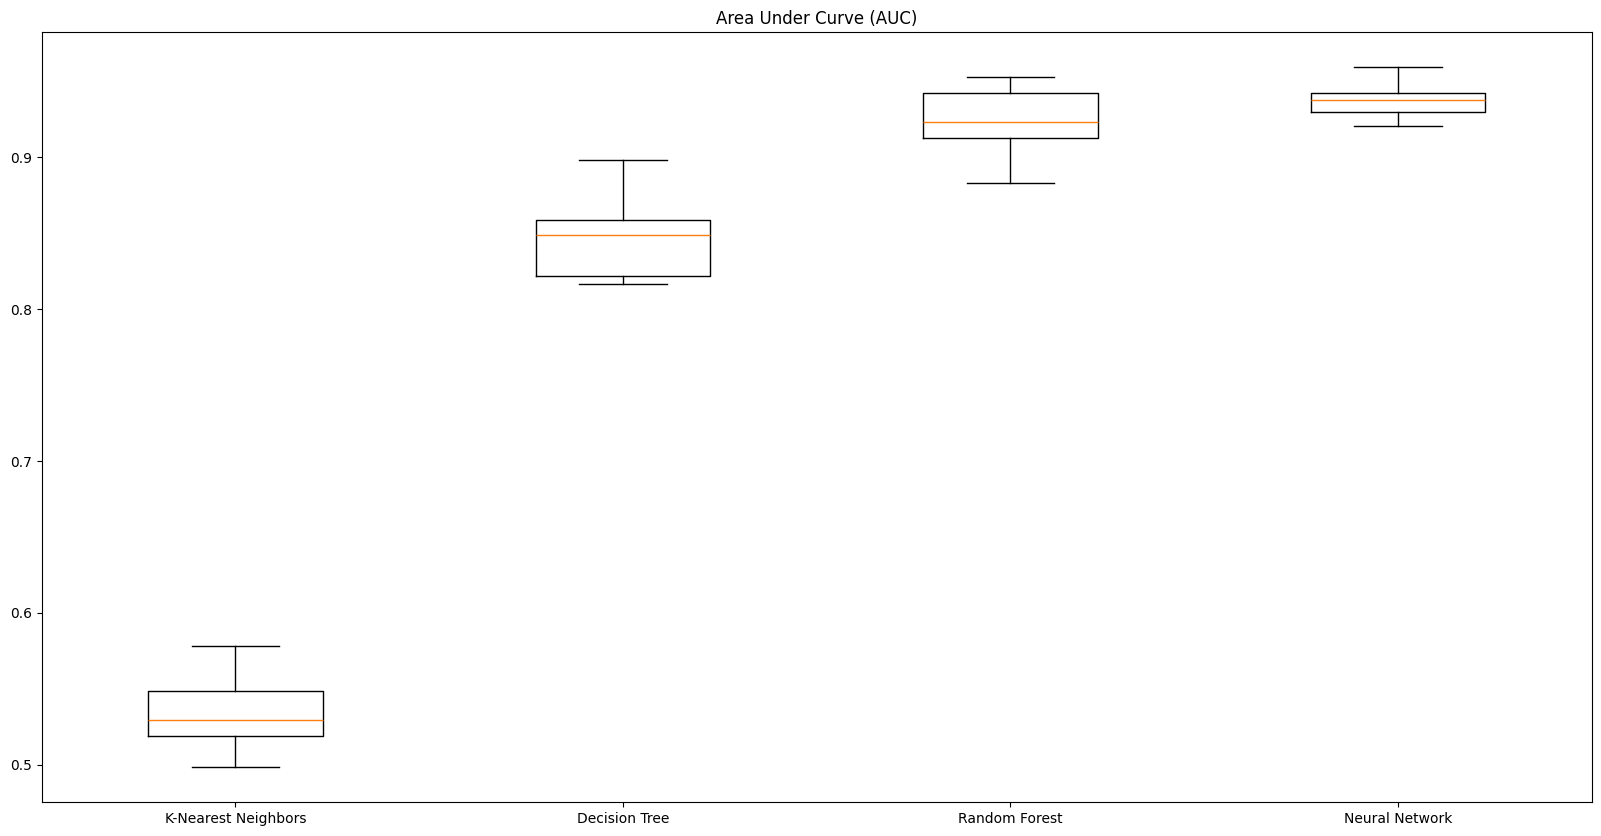

In [12]:
models = [knn, decision_tree, random_forest, neural_network]
labels = ['K-Nearest Neighbors', 'Decision Tree', 'Random Forest', 'Neural Network']

scores = []
for model in models:
    pipeline = imbpipeline([
        ['smote', smote],
        ['scaler', scaler],
        ['classifier', model]
    ])
    score = cross_val_score(pipeline, predictors, targets, cv = cross_validation, n_jobs = -1, scoring = 'roc_auc')
    scores.append(score)

plt.figure(figsize = (20, 10))
plt.boxplot(scores, labels = labels)
plt.title('Area Under Curve (AUC)')

### Revisão do Processo

### Determinação dos Próximos Passos

## Produção

In [13]:
customers = pd.read_csv('kaggle/customers.csv')
merchants = pd.read_csv('kaggle/merchants.csv')
transactions = pd.read_csv('kaggle/test_transactions.csv')

def data_selection(transactions):
    transactions = transactions.drop('trans_date_trans_time', axis = 1)
    return transactions

def data_cleaning(transactions):
    transactions['device_os'] = transactions['device_os'].fillna('unknown')
    transactions = transactions.drop('trans_num', axis = 1)
    return transactions

def data_construction(transactions):
    # day, month, weekday
    timestamp = pd.to_datetime(transactions['unix_time'], unit = 's')
    transactions['day'] = timestamp.dt.day
    transactions['month'] = timestamp.dt.month
    transactions['weekday'] = timestamp.dt.weekday
    # days_since_last_transaction
    transactions = transactions.sort_values(by = ['cc_num', 'unix_time'])
    transactions['days_since_last_transaction'] = transactions.groupby('cc_num')['unix_time'].diff()
    transactions['days_since_last_transaction'] = transactions['days_since_last_transaction'] / (60 * 60 * 24)
    transactions['days_since_last_transaction'] = transactions['days_since_last_transaction'].fillna(0)
    # merchant_transactions_count
    transactions = transactions.sort_values(by = ['cc_num', 'merchant', 'unix_time'])
    transactions['merchant_transactions_count'] = transactions.groupby(['cc_num', 'merchant']).cumcount()
    transactions = transactions.drop('unix_time', axis = 1)
    return transactions

def data_integration(transactions, merchants, customers):
    data = transactions.merge(merchants, on = 'merchant').merge(customers, on = 'cc_num')
    data = data.drop(['cc_num', 'merchant'], axis = 1)
    return data

def data_formatting(data):
    data = pd.get_dummies(data, drop_first = False)
    data['device_os_Linux'] = False # TODO
    data = data.sort_index(axis = 1)
    return data

data = transactions.pipe(data_selection).pipe(data_cleaning).pipe(data_construction).pipe(data_integration, merchants, customers).pipe(data_formatting)

data.head()

,age,amt,category_Apparel,category_Electronics,category_Entertainment,category_Groceries,category_Travel,city_Chicago,city_Houston,city_Los Angeles,...,job_Artist,job_Clerk,job_Doctor,job_Engineer,job_Lawyer,job_Nurse,job_Teacher,merchant_transactions_count,month,weekday
0,31,483.368265,False,False,False,True,False,True,False,False,...,False,False,False,True,False,False,False,0,12,2
1,21,236.803300,False,False,False,True,False,True,False,False,...,False,False,False,False,False,True,False,0,8,3
2,21,181.193456,False,False,True,False,False,True,False,False,...,False,False,False,False,False,True,False,0,2,0
3,29,22.241488,True,False,False,False,False,True,False,False,...,False,False,False,False,False,True,False,0,9,5
4,69,293.482287,False,False,False,True,False,False,True,False,...,False,False,False,True,False,False,False,0,1,1


In [15]:
svm = SVC(random_state = 10, probability = True)

svm_pipeline = imbpipeline([
    ['smote', smote],
    ['scaler', scaler],
    ['classifier', svm]
])

svm_parameter_grid = {
    'classifier__kernel': ['linear', 'poly', 'rbf', 'sigmoid'],
    'classifier__gamma': ['scale', 'auto']
}

svm_grid_search = GridSearchCV(svm_pipeline, svm_parameter_grid, cv = cross_validation, n_jobs = -1, scoring = 'roc_auc')

svm_grid_search.fit(train_predictors, train_targets)

svm_auc = svm_grid_search.score(test_predictors, test_targets)

print('Support Vector Machine Best AUC Score: {:.2f}%'.format(svm_grid_search.best_score_ * 100))
print('Support Vector Machine Best Parameters:', svm_grid_search.best_params_)
print('Support Vector Machine Test Score: {:.2f}%'.format(svm_auc * 100))

print(classification_report(test_targets, svm_grid_search.predict(test_predictors)))

probabilities = svm_grid_search.predict_proba(data)[:, 1]

predictions = pd.DataFrame({
    'index': data['index'],
    'is_fraud': probabilities
})

predictions.to_csv('kaggle/predictions.csv', index = False)

Support Vector Machine Best AUC Score: 88.46%
Support Vector Machine Best Parameters: {'classifier__gamma': 'scale', 'classifier__kernel': 'rbf'}
Support Vector Machine Test Score: 89.11%
              precision    recall  f1-score   support

           0       0.98      1.00      0.99      7199
           1       1.00      0.01      0.01       144

    accuracy                           0.98      7343
   macro avg       0.99      0.50      0.50      7343
weighted avg       0.98      0.98      0.97      7343

